### Imports

In [49]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from collections import Counter
from IPython.display import display, HTML
import time

## 1. Finding Similar Costumers
Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study.

https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/

### 1.1 Set up the data
To start working download the banking dataset on Kaggle.

For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and **try to understand which features will be appropriate** for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

In [83]:
data = pd.read_csv('archive.zip').dropna()

In [84]:
data['CustomerDOB'] = pd.to_datetime(data.CustomerDOB)

In [85]:
data['TransactionDate'] = pd.to_datetime(data.TransactionDate)

In [86]:
data['TransactionTime'] = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [87]:
data['TransactionTime'] = data.TransactionTime.dt.time

In [88]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,18:48:24,799.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0


We are using the following collums for the procedure. However later, we transform the account balance and the transaction amount to integers and for the date of birth we only consider the year.

In [89]:
keepcols = ['CustLocation', 
            'CustAccountBalance', 
            'TransactionAmount (INR)', 
            'CustomerDOB', 
            'CustGender', 
            'TransactionDate', 
            'TransactionTime']

In [90]:
df = data[keepcols]

In [92]:
# Using pd.get_dummies pretty much computes the characteristic matrix for us.

m_locs = pd.get_dummies(df[keepcols[0]], sparse=True)

m_bals = pd.get_dummies(df[keepcols[1]].astype(int), prefix='B', sparse=True)
m_amos = pd.get_dummies(df[keepcols[2]].astype(int), prefix='A', sparse=True)

m_yobs = pd.get_dummies(df[keepcols[3]].dt.year.astype(int), prefix='YOB', sparse=True)

m_gend = pd.get_dummies(df[keepcols[4]], prefix='G')

m_trans_month = pd.get_dummies(df[keepcols[5]].dt.month.astype(int), prefix='TRANS_M')

m_trans_time = pd.get_dummies(df[keepcols[6]].apply(lambda row: row.hour).astype(int), prefix='TRANS_H')

print("See the characteristic matrix for the bith years for example:")
m_yobs

See the characteristic matrix for the bith years for example:


,YOB_1800,YOB_1972,YOB_1973,YOB_1974,YOB_1975,YOB_1976,YOB_1977,YOB_1978,YOB_1979,YOB_1980,...,YOB_2062,YOB_2063,YOB_2064,YOB_2065,YOB_2066,YOB_2067,YOB_2068,YOB_2069,YOB_2070,YOB_2071
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048565,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
print('Number of locations:', 2*'\t', len(m_locs.columns))
print('Number of balances:', 2*'\t',len(m_bals.columns))
print('Number of birth years:', 2*'\t', len(m_yobs.columns))
print('Number of genders:', 2*'\t', len(m_gend.columns))

Number of locations: 		 9275
Number of balances: 		 76033
Number of birth years: 		 100
Number of genders: 		 3


In [116]:
# Concatenate all partial characteristic matrices to get M

# Since we want to find the most similar customers, include only customer specifc information like:
# The year of birth, gernder, account balance and the location.

M = pd.concat([m_yobs, m_gend, m_bals, m_locs], axis=1).sample(frac=1, axis=1)

# use .sample() to randomly shuffle to shingles to later avoid only, when using only the first m shingles,
# just looking at the locations.

M

,B_39846,B_22272,B_24067,B_457941,B_25383,B_13148,B_16034,SANAPADA,B_79682,B_61961,...,B_15011,B_27780,B_81066,B_100226,MULUND,B_101962,B_24217,RATTAN RAIPUR,B_2837,B_93043
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.2 Fingerprint hashing
Using the previously selected data with the features you found pertinent, you have to:

Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the book.

http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf

Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

In [117]:
def n_random_hash(x, n, p=85451):
    """
    x: integer value to hash
    n: number of hash functions to use
    p: the next larger prime number compared to the number of shingles
    
    returns H: the n hash values
            A: the n random values used to generate the hash values
    """
    
    H = []
    A = []
    
    for i in range(n):
        a = randint(1, n*2) # generate a random integer number
        H.append((lambda x: ((x * a) % p))(i))
        A.append(a)

    return H, A

In [118]:
def n_query_hash(x, n, a_to_use, p=85451):
    """
    Essentially the same method as above, except we are not generating
    random values, but using the same random values as used for the 
    signature matrix.
    """
    
    H = []
    
    for a, i in zip(a_to_use, range(n)):
        H.append((lambda x: ((x * a) % p))(i))

    return H

In [119]:
def construct_sig_on_m(n, m, M):
    """
    n: the number of hash functions to use
    m: the number of shingles to consider for similarity
    M: the characteristic matrix for our dataset
    
    returns SIG: the n x N signature matrix for the k x N characteristic matrix 
                 with N the number of transactions, k the number of shingles.
            A:   all random values used for the hashing 
    """    
    A = []
    
    SIG = np.matrix(np.ones((n, len(M))) * np.inf)
        
    M = M[M.columns[:m]]
    
    for rix, r in enumerate(M.columns): # iterate over shingles
        H, random_factors = n_random_hash(rix+1, n)
        A.append(random_factors)
        
        nonzero = np.where(M[r] == 1) # get indices of columns that have shingle r
        
        for ix in range(n):
            SIG[ix, nonzero] = np.minimum(SIG[ix, nonzero], H[ix])
       
    return SIG, A

In [120]:
def construct_query_sig(n, m, M, Q, random_values):
    """
    Essentially the same function as above, except this time we use the random values
    from the previous function and we use
    Q: the characteristic matrix of the query.
    
    returns SIG: the signature of the query
    """
    
    SIG = np.matrix(np.ones((n, 2)) * np.inf)
        
    M = M[M.columns[:m]]
    
    for rix, r in enumerate(M.columns):
        H = n_query_hash(rix+1, n, a_to_use=random_values[rix])
        
        if r in Q.columns:
            nonzero = 0
        else:
            nonzero = 1
                
        for ix in range(n):
            SIG[ix, nonzero] = np.minimum(SIG[ix, nonzero], H[ix])
    
    return SIG

In [121]:
def inf_ratio(mat):
    """
    Returns the fraction of inf values in the signature matrix.
    """
    
    num_entries = mat.shape[0] * mat.shape[1]
    num_inf = np.count_nonzero(mat == np.inf)
    return (num_inf / num_entries)

Using $\sum^n_{i=1} a_i * x_i$ ``mod`` $p$ as hash function with $p = 1041643$, one of the closest prime numbers to the number of customers, and uniform and random distributed $a_i$ we get the following method. The logic of this hash function and the previous hash functions is taken from the lecture.

In [122]:
def hash_signature_band(x, p=1041643, a=None):  
    """
    Hashes a band of size r single hash N hash values.
    Uses parameter a if we are handling the query.
    """
    
    r = len(x) 
    
    if a is None:
        a = np.random.randint(1, r+1, size=r).reshape((r, 1))
    
    v = np.sum((a * x), axis=0)
    
    return v, a

In [123]:
def lsh(mat, b=20, r=5, A=None):
    """
    Performs the LSH algorithm
    """
    
    if A == None:
        temp = [hash_signature_band(np.array(mat[i:i+r, :])) for i in range(0, b*r, r)]
    else:
        temp = [hash_signature_band(np.array(mat[i:i+r, :]), a=a) for i, a in zip(range(0, b*r, r), A)]
    
    buckets = [b for b, a in temp]
    band_A = [a for b, a in temp]
    
    return buckets, band_A

In [124]:
def get_bucket_dict(bands):
    """
    Creates a dictionary that stores for each bucket the indices of transactions that got mapped
    to this bucket.
    """
    
    band_df = pd.DataFrame(np.transpose(np.array(bands)))
    d = {}
    
    for v in range(len(band_df)):
        [d.setdefault(k, []).append(v) for k in band_df.iloc[v]]
    
    return d

In [125]:
def what_is_t(b, r):
    """
    Method to compute the threshold t.
    """
    return (1/b) ** (1/r)

### 1.3 Locality Sensitive Hashing
Now that you prepared your algorithm, it's query time!
We have prepared some dummy users for you to work with.

Download this csv and report the most similar users (comparing them against the dataset provided in Kaggle).
Did your hashing method work properly, what scores have you obtained and how long did it take to run? Provide information and analysis about the results.

#### Prepare query data

In [126]:
query_data = pd.read_csv('query_users.csv')
query_data['CustomerDOB'] = pd.to_datetime(query_data.CustomerDOB)

query_data['TransactionDate'] = pd.to_datetime(query_data.TransactionDate)
query_data['TransactionTime'] = query_data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
query_data['TransactionTime'] = query_data.TransactionTime.dt.time

query_db = query_data[keepcols]

In [127]:
def get_queries(query_df):
    
    queries = []

    for i in range(len(query_df)):
        query_db = query_df.iloc[i:i+1]
        q_locs = pd.get_dummies(query_db[keepcols[0]], sparse=True)

        q_bals = pd.get_dummies(query_db[keepcols[1]].astype(int), prefix='B', sparse=True)
        q_amos = pd.get_dummies(query_db[keepcols[2]].astype(int), prefix='A', sparse=True)

        q_yobs = pd.get_dummies(query_db[keepcols[3]].dt.year.astype(int), prefix='Y', sparse=True)
     
        q_gend = pd.get_dummies(query_db[keepcols[4]], prefix='G')
        
        q_trans_month = pd.get_dummies(query_db[keepcols[5]].dt.month.astype(int), prefix='TRANS_M')

        q_trans_time = pd.get_dummies(query_db[keepcols[6]].apply(lambda row: row.hour).astype(int), prefix='TRANS_H')


        Q = pd.concat([q_yobs, q_gend, q_bals, q_locs], axis=1).sample(frac=1, axis=1)
        
        queries.append(Q)
    
    return queries

In [128]:
Qs = get_queries(query_db)

In [129]:
for q in Qs[:3]:
    display(q)

,B_94695,G_M,Y_1978,DELHI
0,1,1,1,1


,Y_1992,B_7584,G_M,PANCHKULA
1,1,1,1,1


,Y_1991,G_M,PATNA,B_7180
2,1,1,1,1


#### Run query

In [130]:
def get_k_recommendations(query_buckets, d, k=3):
    """
    After having computed the signature matirx for a query and having mapped
    its bands to buckets, we now can look up those query buckets in the dictionary
    of buckets from the signature matrix for the data.
    """
    
    candidates = []

    for qb in query_buckets: # for every query bucket
        try: 
            candidates.append(d[qb[0]]) # collect all candidates
        except:
            pass
        
    flat_candidates = [candidate for sublist in candidates for candidate in sublist]
    
    K = []

    for k,v in Counter(flat_candidates).most_common(k):
        K.append(k)
        
    return df.iloc[K] # and return the k most common

In [131]:
t0 = time.time()
m = int(len(M.columns)) # we are using all shingle
signature_matrix, A = construct_sig_on_m(n=100, m=m, M=M)
print(f'Construction of the signature matrix took {time.time() - t0:.2f} seconds')

Construction of the signature matrix took 113.16 seconds


In [132]:
b = 20
r = 5

In [133]:
what_is_t(b, r)

0.5492802716530588

In [134]:
t0 = time.time()
bands, band_A = lsh(signature_matrix, b, r)
print(f'Hashing of the bands took {time.time() - t0:.2f} seconds')

Hashing of the bands took 0.50 seconds


In [135]:
t0 = time.time()
d = get_bucket_dict(bands)
print(f'Saving the candidates for each band hash value took {time.time() - t0:.2f} seconds')

Saving the candidates for each band hash value took 52.76 seconds


In [136]:
t0 = time.time()
result = []

for ix, query in enumerate(Qs):
    t1 = time.time()
    query_sig = construct_query_sig(n=100, m=m, M=M, Q=query, random_values=A)
    q_bands, _ = lsh(query_sig[:, 0], b, r, band_A)
    
    top_k = get_k_recommendations(q_bands, d)
    display(top_k)
    
    result.append([ix, top_k.index])
    
    display(query_db.iloc[ix:ix+1])
    print(f'Query number {ix+1} took {time.time() - t1:.2f} seconds')
    print('-', ' # ' * 24, '-')
    
print(f'All queries together took {time.time() - t0:.2f} seconds')

,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
13236,DELHI,94695.61,10.06,1978-07-27,M,2016-09-26,22:41:43
37224,DELHI,94695.61,14.43,1978-07-27,M,2016-09-30,20:25:32
83263,DELHI,94695.61,65.00,1978-07-27,M,2016-02-08,14:03:00


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
0,DELHI,94695.61,65.0,1978-07-27,M,2016-02-09,14:03:10


Query number 1 took 24.02 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
48947,PANCHKULA,7584.09,124.47,1992-06-11,M,2016-03-08,14:40:18
59588,PANCHKULA,7584.09,90.00,1992-06-11,M,2016-03-08,20:32:08
63347,PANCHKULA,7584.09,79.74,1992-06-11,M,2016-02-08,10:45:56


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
1,PANCHKULA,7584.09,6025.0,1992-06-11,M,2016-02-09,12:02:14


Query number 2 took 21.16 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
67717,PATNA,7180.6,1128.00,1991-08-14,M,2016-02-08,13:34:58
154137,PATNA,7180.6,49.00,1991-08-14,M,2016-04-08,05:35:29
291248,PATNA,7180.6,590.85,1991-08-14,M,2016-11-08,23:03:24


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
2,PATNA,7180.6,541.5,1991-08-14,M,2016-10-08,22:17:32


Query number 3 took 21.29 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
68841,CHENNAI,56847.75,1409.0,1987-03-01,M,2016-02-08,13:12:52
74996,CHENNAI,56847.75,250.0,1987-03-01,M,2016-02-08,19:05:40
139808,CHENNAI,56847.75,11990.0,1987-03-01,M,2016-05-08,13:39:21


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
3,CHENNAI,56847.75,1000.0,1987-03-01,M,2016-08-29,14:41:38


Query number 4 took 23.48 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
293629,GURGAON,32575.17,50.00,1982-09-09,M,2016-10-08,10:27:41
303845,GURGAON,32575.17,359.00,1982-09-09,M,2016-10-08,11:38:07
354480,GURGAON,32575.17,3321.52,1982-09-09,M,2016-08-14,19:49:32


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
4,GURGAON,84950.13,80.0,1995-04-01,M,2016-09-25,23:33:09


Query number 5 took 21.03 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
56177,WORLD TRADE CENTRE BANGALORE,23143.95,699.0,1981-10-01,M,2016-03-08,19:58:50
58226,WORLD TRADE CENTRE BANGALORE,23143.95,2694.0,1981-10-01,M,2016-03-08,20:49:05
165088,WORLD TRADE CENTRE BANGALORE,23143.95,599.0,1981-10-01,M,2016-04-08,16:37:10


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
5,WORLD TRADE CENTRE BANGALORE,23143.95,303.0,1981-10-01,M,2016-11-09,19:29:06


Query number 6 took 23.37 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
78071,CHITTOOR,15397.8,20.0,1976-09-20,F,2016-02-08,14:47:11
147746,CHITTOOR,15397.8,30.0,1976-09-20,F,2016-04-08,01:09:17
150895,CHITTOOR,15397.8,20.0,1976-09-20,F,2016-05-08,13:33:11


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
6,CHITTOOR,15397.8,20.0,1976-09-20,F,2016-08-28,09:26:33


Query number 7 took 21.03 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
21984,MOHALI,426.3,20.0,1991-10-04,M,2016-09-23,13:12:33
79635,MOHALI,426.3,50.0,1991-10-04,M,2016-02-08,20:37:54
144794,MOHALI,426.3,20.0,1991-10-04,M,2016-05-08,20:05:33


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
7,MOHALI,426.3,50.0,1991-10-04,M,2016-02-08,20:37:54


Query number 8 took 23.75 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
799656,MOHALI,81.98,500.0,1981-10-04,M,2016-05-09,14:43:07
800699,MOHALI,81.98,280.0,1981-10-04,M,2016-05-09,18:02:33
1721,MOHALI,54507.64,100.0,1981-10-01,M,2016-10-21,22:37:17


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
8,MOHALI,4609.34,300.0,1990-03-19,M,2016-08-26,18:40:15


Query number 9 took 21.05 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
24582,SERAMPORE,6695988.46,7082.00,2070-12-19,M,2016-09-26,17:09:50
91586,SERAMPORE,6695988.46,1226.58,2070-12-19,M,2016-09-22,13:04:22
118978,SERAMPORE,6695988.46,1301.00,2070-12-19,M,2016-06-08,15:01:26


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
9,SERAMPORE,6695988.46,299.0,2070-12-19,M,2016-08-27,14:40:30


Query number 10 took 23.83 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
86487,BANGALORE,5974.56,300.0,1989-02-26,M,2016-01-08,09:13:22
126684,BANGALORE,5974.56,300.0,1989-02-26,M,2016-06-08,22:01:51
249676,BANGALORE,5974.56,300.0,1989-02-26,M,2016-07-08,21:21:59


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
10,BANGALORE,5974.56,300.0,1989-02-26,M,2016-06-08,22:01:51


Query number 11 took 21.13 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
294910,BANGALORE,268.09,2244.0,1984-08-22,M,2016-11-08,20:31:31
431607,BANGALORE,268.09,1304.0,1984-08-22,M,2016-08-17,20:08:26
222003,BANGALORE,268.82,336.0,1991-08-16,M,2016-08-08,21:14:30


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
11,BANGALORE,268.09,2244.0,1984-08-22,M,2016-11-08,20:31:31


Query number 12 took 23.54 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
569694,LUDHIANA,38785.44,690.0,1979-09-21,M,2016-08-22,18:59:53
17415,PUNE,60937.86,200.0,1978-11-16,F,2016-09-26,15:02:35
17954,PUNE,60937.86,250.0,1978-11-16,F,2016-09-26,16:17:13


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
12,LUDHIANA,38785.44,690.0,1979-09-21,M,2016-08-22,18:59:53


Query number 13 took 21.00 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
149705,BANGALORE,19767.76,633.0,1992-06-17,F,2016-05-08,18:43:14
211188,BANGALORE,19767.76,29.0,1992-06-17,F,2016-03-09,13:12:58
278321,BANGALORE,19767.76,4912.0,1992-06-17,F,2016-12-08,23:28:22


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
13,BANGALORE,19767.76,4912.0,1992-06-17,F,2016-12-08,23:28:22


Query number 14 took 21.14 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
100252,HYDERABAD,21713.09,300.0,1986-01-08,M,2016-01-08,13:43:58
208306,HYDERABAD,21713.09,250.0,1986-01-08,M,2016-08-08,06:09:07
290871,HYDERABAD,21713.09,270.0,1986-01-08,M,2016-11-08,14:03:36


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
14,HYDERABAD,21713.09,284.0,1986-01-08,M,2016-11-09,15:01:36


Query number 15 took 23.42 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
10126,GURGAON,15599.22,460.00,1987-08-28,M,2016-09-25,19:22:58
34368,GURGAON,15599.22,206.69,1987-08-28,M,2016-09-25,19:23:31
35042,GURGAON,5903.03,222.00,1987-03-19,M,2016-09-27,00:36:15


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
15,GURGAON,28333.11,1000.0,1800-01-01,M,2016-08-31,16:03:07


Query number 16 took 21.14 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
153595,MUMBAI,1981.59,401.0,1991-12-17,F,2016-05-08,21:43:23
248727,MUMBAI,1981.59,2500.0,1991-12-17,F,2016-07-08,13:54:57
298236,MUMBAI,1981.59,7750.0,1991-12-17,F,2016-11-08,21:12:11


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
16,MUMBAI,1981.59,401.0,1991-12-17,F,2016-05-08,21:43:23


Query number 17 took 23.46 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
1456,NEW DELHI,155633.09,10.0,1989-09-13,M,2016-10-21,20:00:15
9856,NEW DELHI,14563.19,150.0,1989-08-16,M,2016-09-25,20:19:15
13546,NEW DELHI,20232.98,760.0,1989-10-03,M,2016-09-27,15:20:08


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
17,NEW DELHI,176303.02,1347.0,1800-01-01,M,2016-09-08,13:34:14


Query number 18 took 21.00 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
12125,GURGAON,30.46,2999.0,1981-10-08,M,2016-09-27,17:18:16
16144,GURGAON,37519.05,192.0,2062-05-18,M,2016-09-26,17:47:54
20523,GURGAON,3026768.43,2087.0,2062-08-26,M,2016-09-23,19:15:58


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
18,GURGAON,27930.23,60.0,1993-07-07,M,2016-08-09,02:52:12


Query number 19 took 23.31 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
51136,CHENNAI,6399.24,290.0,1989-06-21,M,2016-03-08,17:58:22
54007,CHENNAI,6399.24,295.0,1989-06-21,M,2016-03-08,18:45:16
59641,CHENNAI,6399.24,404.0,1989-06-21,M,2016-03-08,20:13:28


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
19,CHENNAI,6399.24,404.0,1989-06-21,M,2016-03-08,20:13:28


Query number 20 took 20.96 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
47263,NOIDA,498859.06,374.0,1982-09-18,F,2016-03-08,13:44:17
117360,NOIDA,498859.06,719.0,1982-09-18,F,2016-06-08,15:12:04
117828,NOIDA,498859.06,1497.0,1982-09-18,F,2016-06-08,15:46:38


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
20,NOIDA,498859.06,40000.0,1982-09-18,F,2016-08-22,09:49:01


Query number 21 took 23.59 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
6767,BANGALORE,6379.07,1484.0,2064-06-09,F,2016-09-25,19:28:55
7398,BANGALORE,6379.07,652.0,2064-06-09,F,2016-09-27,19:44:32
12389,BANGALORE,6379.07,245.0,2064-06-09,F,2016-09-22,12:52:40


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
21,BANGALORE,108941.24,1280.0,2062-08-21,F,2016-09-14,15:41:53


Query number 22 took 21.11 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
36693,NEW DELHI,125934.77,200.0,1988-08-17,M,2016-09-30,14:55:13
52750,NEW DELHI,125934.77,30.0,1988-08-17,M,2016-03-08,16:25:17
111725,NEW DELHI,125934.77,200.0,1988-08-17,M,2016-06-08,11:47:11


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
22,NEW DELHI,125934.77,197.0,1988-08-17,M,2016-10-08,10:48:36


Query number 23 took 23.51 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
656802,AHMEDABAD,47403.83,3460.0,2065-05-12,M,2016-08-28,19:55:59
821095,AHMEDABAD,47403.83,1656.0,2065-05-12,M,2016-04-09,19:54:01
359907,DELHI,19453.15,540.0,1980-05-25,M,2016-08-14,21:45:48


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
23,AHMEDABAD,47403.83,3460.0,2065-05-12,M,2016-08-28,19:55:59


Query number 24 took 21.00 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
79703,PRAKASAM DIST (AP),26655.05,200.0,1994-10-07,M,2016-02-08,20:45:58
82521,PRAKASAM DIST (AP),26655.05,150.0,1994-10-07,M,2016-02-08,22:05:53
196747,PRAKASAM DIST (AP),26655.05,200.0,1994-10-07,M,2016-08-08,08:33:46


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
24,PRAKASAM DIST (AP),26655.05,150.0,1994-10-07,M,2016-02-08,22:05:53


Query number 25 took 23.41 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
96981,BANGALORE,10072.85,300.0,1975-10-25,M,2016-01-08,17:56:41
104188,BANGALORE,10072.85,1821.0,1975-10-25,M,2016-01-08,21:16:07
111533,BANGALORE,10072.85,300.0,1975-10-25,M,2016-06-08,11:43:03


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
25,BANGALORE,10072.85,862.44,1975-10-25,M,2016-04-08,14:45:51


Query number 26 took 21.02 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
6846,VADODARA,101424.95,990.0,1989-01-11,M,2016-09-25,18:35:41
25784,VADODARA,101424.95,39.0,1989-01-11,M,2016-09-22,12:18:02
47655,VADODARA,101424.95,179.0,1989-01-11,M,2016-03-08,13:27:12


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
26,VADODARA,101424.95,990.0,1989-01-11,M,2016-09-25,18:35:41


Query number 27 took 21.08 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
4710,MUMBAI,64389.91,260.0,1983-10-16,M,2016-08-20,13:06:11
12505,MUMBAI,64389.91,400.0,1983-10-16,M,2016-09-25,22:42:24
126781,MUMBAI,64389.91,599.0,1983-10-16,M,2016-06-08,18:35:50


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
27,MUMBAI,64389.91,220.0,1983-10-16,M,2016-09-09,19:33:08


Query number 28 took 23.53 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
55932,HYDERABAD,12793.16,235.00,1987-02-16,M,2016-03-08,19:49:16
60795,HYDERABAD,12793.16,176.00,1987-02-16,M,2016-03-08,20:14:52
61157,HYDERABAD,12793.16,312.78,1987-02-16,M,2016-03-08,20:44:04


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
28,HYDERABAD,12793.16,199.0,1987-02-16,M,2016-08-08,21:20:21


Query number 29 took 21.24 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
6300,JODHPUR,715.83,280.00,1800-01-01,M,2016-09-25,22:11:52
10878,JODHPUR,715.83,60.00,1800-01-01,M,2016-09-27,16:40:39
34882,JODHPUR,715.83,474.48,1800-01-01,M,2016-09-30,13:47:33


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
29,MUMBAI,205.7,1933.52,1800-01-01,M,2016-08-30,16:00:56


Query number 30 took 23.57 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
16566,AURANGABAD,170981.48,56.0,1986-10-12,M,2016-09-26,16:53:19
49245,AURANGABAD,170981.48,611.0,1986-10-12,M,2016-03-08,13:16:13
94432,AURANGABAD,170981.48,200.0,1986-10-12,M,2016-01-08,13:58:33


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
30,AURANGABAD,170981.48,1137.0,1986-10-12,M,2016-07-08,20:52:42


Query number 31 took 21.22 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
184627,DELHI,11716.39,4807.0,2066-09-13,M,2016-09-08,15:06:31
272118,DELHI,11716.39,50.0,2066-09-13,M,2016-12-08,14:34:04
796017,NAGPUR,374999.75,2700.0,1973-08-09,M,2016-05-09,14:14:51


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
31,HODEL,995009.07,3000.0,2069-06-06,M,2016-04-08,18:10:55


Query number 32 took 23.65 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
24078,CHENNAI,6771.64,238.99,1800-01-01,M,2016-09-26,18:07:12
85177,CHENNAI,6771.64,2026.00,1800-01-01,M,2016-01-08,14:50:16
93421,CHENNAI,6771.64,386.00,1800-01-01,M,2016-09-22,14:53:54


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
32,CHENNAI,6771.64,282.9,1800-01-01,M,2016-08-17,21:14:38


Query number 33 took 21.13 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
844799,NEW DELHI,103832.66,1290.23,1984-07-04,F,2016-09-09,14:18:46
8741,VADODARA,23085.40,200.00,1986-10-24,F,2016-09-27,18:47:02
360230,LUCKNOW,1572.00,2374.00,1993-07-05,M,2016-08-14,22:58:07


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
33,NEW DELHI,103832.66,1290.23,1984-07-04,F,2016-09-09,14:18:46


Query number 34 took 23.38 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
11091,SECUNDERABAD,602296.81,670.68,1991-09-15,M,2016-09-26,21:45:22
19851,SECUNDERABAD,602296.81,2222.00,1991-09-15,M,2016-09-26,15:16:57
658208,SECUNDERABAD,602296.81,103.24,1991-09-15,M,2016-08-31,15:55:59


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
34,SECUNDERABAD,602296.81,2937.48,1991-09-15,M,2016-11-09,18:46:55


Query number 35 took 21.02 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
155335,GURGAON,4.09,50.0,1979-06-18,M,2016-03-09,16:18:13
155373,GURGAON,4.09,53.2,1979-06-18,M,2016-03-09,15:06:05
265571,GURGAON,4.09,53.9,1979-06-18,M,2016-03-09,11:08:39


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
35,N T PUNE,23299.53,212.0,1991-01-28,F,2016-10-09,22:08:46


Query number 36 took 23.50 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
6321,NEW DELHI,891691.51,264.0,1980-05-21,M,2016-09-25,21:06:20
6753,NEW DELHI,435557.31,1400.0,1980-09-10,M,2016-09-25,20:49:39
10444,NEW DELHI,435557.31,3058.0,1980-09-10,M,2016-09-25,22:55:48


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
36,NEW DELHI,398248.26,3180.0,1986-06-02,M,2016-01-08,22:04:03


Query number 37 took 21.07 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
164573,BANGALORE,1660.81,1000.0,1982-06-28,M,2016-04-08,12:08:26
209335,BANGALORE,1660.81,200.0,1982-06-28,M,2016-03-09,12:55:26
210797,BANGALORE,1660.81,200.0,1982-06-28,M,2016-03-09,12:54:45


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
37,BANGALORE,1660.45,100.86,1987-07-31,M,2016-08-14,20:39:11


Query number 38 took 23.75 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
643902,NEW DELHI,11349.1,1051.0,1980-06-06,M,2016-08-25,14:10:00
761937,NEW DELHI,11349.1,1051.0,1980-06-06,M,2016-01-09,13:52:42
794755,NEW DELHI,11349.1,150.0,1980-06-06,M,2016-05-09,14:58:05


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
38,NEW DELHI,11349.64,5598.0,1984-05-29,M,2016-02-09,14:47:24


Query number 39 took 21.13 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
292390,HYDERABAD,1469.23,30.0,1989-05-17,M,2016-11-08,20:02:56
875753,HYDERABAD,1469.23,20.0,1989-05-17,M,2016-08-09,20:49:09
915460,HYDERABAD,1469.23,30.0,1989-05-17,M,2016-12-09,19:34:20


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
39,HYDERABAD,10994.33,60.0,1988-01-22,M,2016-02-08,15:37:12


Query number 40 took 21.18 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
3877,CHENNAI,66148.37,265.00,1983-07-28,M,2016-09-22,08:15:33
6936,CHENNAI,15368.87,200.00,1983-06-15,M,2016-09-22,12:40:30
17621,CHENNAI,31266.50,185.43,1980-05-01,M,2016-09-26,20:11:42


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
40,CHENNAI,2887.39,20.0,1987-02-18,M,2016-08-24,18:17:03


Query number 41 took 23.77 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
4289,MUMBAI,397185.14,625.84,1980-05-27,M,2016-09-22,09:19:37
32576,MUMBAI,397185.14,3800.00,1980-05-27,M,2016-09-26,14:03:02
38647,MUMBAI,397185.14,244.00,1980-05-27,M,2016-09-27,19:02:26


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
41,IMPHAL,31987.86,203.0,1986-01-03,M,2016-08-19,14:57:12


Query number 42 took 21.36 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
189168,NEW DELHI,6956.46,115.0,1993-04-03,F,2016-09-08,16:12:42
273544,NEW DELHI,6956.46,1131.0,1993-04-03,F,2016-12-08,21:47:29
278062,NEW DELHI,6956.46,560.0,1993-04-03,F,2016-12-08,23:51:54


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
42,NEW DELHI,85626.45,1500.0,1981-02-11,F,2016-12-09,10:56:36


Query number 43 took 23.46 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
163069,NEW DELHI,163.86,350.0,1993-03-10,F,2016-04-08,15:03:19
191997,NEW DELHI,76677.17,17459.0,1984-10-30,F,2016-09-08,18:49:30
195511,NEW DELHI,163.86,200.0,1993-03-10,F,2016-09-08,20:37:07


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
43,NEW DELHI,3156.39,199.0,1990-02-12,F,2016-04-08,20:46:16


Query number 44 took 21.12 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
5541,PUNE,3362.29,50.0,1985-02-12,M,2016-09-22,14:40:49
187696,PUNE,3362.29,1810.0,1985-02-12,M,2016-09-08,14:15:20
212350,PUNE,3362.29,300.0,1985-02-12,M,2016-08-08,16:20:31


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
44,GHAZIABAD,225234.23,347.3,1972-06-09,M,2016-08-24,17:10:54


Query number 45 took 23.71 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
55661,DELHI,139192.61,684.0,1984-01-07,F,2016-03-08,19:22:05
70978,DELHI,139192.61,849.0,1984-01-07,F,2016-02-08,19:25:22
71515,DELHI,139192.61,133.0,1984-01-07,F,2016-02-08,17:23:50


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
45,DELHI,1089764.73,250.0,1990-05-30,F,2016-05-09,13:05:29


Query number 46 took 21.07 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
24681,CHENNAI,104.8,1400.0,1980-02-06,M,2016-09-22,13:08:15
103936,CHENNAI,11032.9,341.0,1989-12-05,M,2016-01-08,19:33:03
480017,CHENNAI,104.8,3913.0,1980-02-06,M,2016-08-21,20:27:11


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
46,CHENNAI,24678.92,60.0,1974-09-26,M,2016-08-17,21:58:06


Query number 47 took 23.51 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
18051,VARANASI,31359.11,1975.00,2048-02-15,F,2016-09-26,16:59:10
67513,VARANASI,31359.11,2189.93,2048-02-15,F,2016-02-08,17:19:31
71762,VARANASI,31359.11,2100.00,2048-02-15,F,2016-02-08,16:43:56


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
47,DIST NORTH GOA BARDEZ,518766.4,90.0,1991-02-07,M,2016-09-14,18:22:51


Query number 48 took 21.15 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
18643,TRICHY,11726.71,122.0,1987-04-29,M,2016-09-26,13:34:21
108768,TRICHY,11726.71,140.0,1987-04-29,M,2016-06-08,07:28:41
161906,TRICHY,11726.71,465.5,1987-04-29,M,2016-04-08,11:39:47


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
48,PUNE,8085.25,1014.0,1994-07-04,F,2016-05-09,19:12:33


Query number 49 took 23.70 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
47531,DELHI,10989.03,248.0,1984-05-01,M,2016-03-08,14:07:26
122855,DELHI,10989.03,903.0,1984-05-01,M,2016-06-08,19:57:59
189901,DELHI,10989.03,430.0,1984-05-01,M,2016-09-08,17:19:48


,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerDOB,CustGender,TransactionDate,TransactionTime
49,DELHI,10989.03,240.0,1987-05-01,M,2016-04-09,11:32:40


Query number 50 took 21.08 seconds
-  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  -
All queries together took 1112.15 seconds


Performing all queries almost takes 20 minutes. 

Looking through the dataframes above, the method finds a lot of exact matches when looking at the date of births and the genders.

In [175]:
sim = []

for qx, top3 in result:
    S1 = set(query_data.loc[qx])
    for dx in top3:
        S2 = set(data.loc[dx, data.columns[2:]])
        sim.append(len(S1.intersection(S2)) / len(S1.union(S2)))
        

Text(0, 0.5, 'Number of query-data matches')

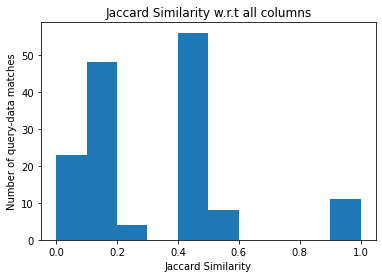

In [176]:
plt.hist(sim)
plt.title("Jaccard Similarity w.r.t all columns")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of query-data matches")

In [177]:
keepcols = ['CustLocation', 
            'CustAccountBalance', 
            'CustomerDOB', 
            'CustGender']

query_db = query_data[keepcols]
df = data[keepcols]

sim = []

for qx, top3 in result:
    S1 = set(query_db.loc[qx])
    for dx in top3:
        S2 = set(df.loc[dx])
        
        sim.append(len(S1.intersection(S2)) / len(S1.union(S2)))

Text(0, 0.5, 'Number of query-data matches')

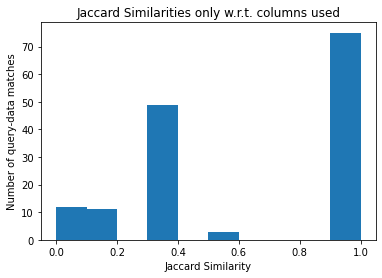

In [178]:
plt.hist(sim)
plt.title("Jaccard Similarities only w.r.t. columns used")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of query-data matches")

Finally, we can see from the two plots that the algorithm suceeds in identifying similar customers with respect to the columns use. When comparing all of the columns used, we look for example at the transaction amounts and dates too, when they are not a good indicator for custimer similarity.